In [25]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm.notebook import tqdm
from PIL import Image

In [26]:
# !pip install ipywidgets

In [27]:
import cv2

In [28]:
img_size=(200,130)

In [29]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/frinks3/RISHABH/ACG/new_classification_train_results' ###################### change dataset folder here

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
len(dataloaders['val'])

14

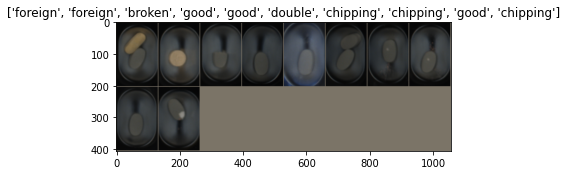

In [31]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [32]:
class_names

['broken', 'chipping', 'double', 'empty', 'foreign', 'good', 'spot']

In [33]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [34]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [35]:
class TabletsModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.efficientnet_b5(pretrained=pretrained)
        
#         print(self.network)
        
#         print(self.network.classifier[1])
        # Replace last layer
        # self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)
        self.network.classifier[1]=nn.Linear(self.network.classifier[1].in_features, num_classes)
        
        # print(self.network.fc)

    def forward(self, xb):
        return self.network(xb)

In [36]:
# a=TabletsModel(6)

# print(a.network)

In [37]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [38]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [39]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [40]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [41]:
# def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
#                   weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,grad_clip=None, opt_func=torch.optim.SGD):

    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [42]:
device = get_default_device()
device

device(type='cuda')

In [43]:
train_dl = DeviceDataLoader(dataloaders['train'], device)
valid_dl = DeviceDataLoader(dataloaders['val'], device)

In [46]:
foreign_added_model = TabletsModel(len(class_names))
to_device(foreign_added_model, device);

In [47]:
history = [evaluate(foreign_added_model, valid_dl)]
history

[{'val_loss': 1.9208961725234985, 'val_acc': 0.15000000596046448}]

In [48]:
epochs =135
max_lr = 0.01
opt_func = torch.optim.Adam

In [49]:
%%time
history += fit_one_cycle(epochs, max_lr,foreign_added_model, train_dl, valid_dl, opt_func=opt_func)

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00041, train_loss: 0.6073, val_loss: 0.3131, val_acc: 0.8929


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00046, train_loss: 0.1597, val_loss: 0.1762, val_acc: 0.9500


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00053, train_loss: 0.1477, val_loss: 0.2045, val_acc: 0.9143


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00063, train_loss: 0.1505, val_loss: 0.1648, val_acc: 0.9429


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00076, train_loss: 0.1877, val_loss: 0.1168, val_acc: 0.9714


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00091, train_loss: 0.1378, val_loss: 0.0467, val_acc: 0.9857


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00109, train_loss: 0.1475, val_loss: 3.5534, val_acc: 0.5929


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00129, train_loss: 0.2059, val_loss: 4.9506, val_acc: 0.4286


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00152, train_loss: 0.2433, val_loss: 2.4538, val_acc: 0.7714


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00177, train_loss: 0.2670, val_loss: 2.8971, val_acc: 0.5714


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [10],last_lr: 0.00204, train_loss: 0.1540, val_loss: 0.9673, val_acc: 0.8643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [11],last_lr: 0.00233, train_loss: 0.1199, val_loss: 0.1554, val_acc: 0.9786


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [12],last_lr: 0.00264, train_loss: 0.3248, val_loss: 0.6394, val_acc: 0.8357


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [13],last_lr: 0.00296, train_loss: 0.2384, val_loss: 0.2499, val_acc: 0.9500


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [14],last_lr: 0.00330, train_loss: 0.3773, val_loss: 9.4881, val_acc: 0.2214


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [15],last_lr: 0.00364, train_loss: 0.2179, val_loss: 0.8295, val_acc: 0.8429


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [16],last_lr: 0.00400, train_loss: 0.0915, val_loss: 0.5185, val_acc: 0.8429


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [17],last_lr: 0.00436, train_loss: 0.1791, val_loss: 3.1842, val_acc: 0.6143


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [18],last_lr: 0.00473, train_loss: 0.4311, val_loss: 49.9926, val_acc: 0.4571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [19],last_lr: 0.00511, train_loss: 0.2868, val_loss: 1.2648, val_acc: 0.7786


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [20],last_lr: 0.00548, train_loss: 0.3046, val_loss: 1.3080, val_acc: 0.6071


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [21],last_lr: 0.00585, train_loss: 0.2561, val_loss: 0.5994, val_acc: 0.8429


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [22],last_lr: 0.00621, train_loss: 0.1749, val_loss: 1.6740, val_acc: 0.7571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [23],last_lr: 0.00658, train_loss: 0.1562, val_loss: 3.4473, val_acc: 0.6643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [24],last_lr: 0.00693, train_loss: 0.3654, val_loss: 105.7242, val_acc: 0.2143


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [25],last_lr: 0.00727, train_loss: 0.3023, val_loss: 1.5564, val_acc: 0.7357


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [26],last_lr: 0.00760, train_loss: 0.1252, val_loss: 1.4246, val_acc: 0.7071


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [27],last_lr: 0.00791, train_loss: 0.0784, val_loss: 0.8350, val_acc: 0.8143


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [28],last_lr: 0.00821, train_loss: 0.2571, val_loss: 2.1895, val_acc: 0.5714


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [29],last_lr: 0.00849, train_loss: 0.2427, val_loss: 0.4342, val_acc: 0.9143


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [30],last_lr: 0.00875, train_loss: 0.1733, val_loss: 0.5537, val_acc: 0.9071


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [31],last_lr: 0.00899, train_loss: 0.2720, val_loss: 7.3274, val_acc: 0.3429


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [32],last_lr: 0.00921, train_loss: 0.5263, val_loss: 30.1990, val_acc: 0.3643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [33],last_lr: 0.00940, train_loss: 0.4180, val_loss: 11.4588, val_acc: 0.5143


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [34],last_lr: 0.00957, train_loss: 0.1776, val_loss: 0.2526, val_acc: 0.9429


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [35],last_lr: 0.00971, train_loss: 0.0786, val_loss: 0.0836, val_acc: 0.9643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [36],last_lr: 0.00982, train_loss: 0.0738, val_loss: 0.3315, val_acc: 0.9071


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [37],last_lr: 0.00991, train_loss: 0.1669, val_loss: 0.2519, val_acc: 0.9286


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [38],last_lr: 0.00997, train_loss: 0.0902, val_loss: 0.5593, val_acc: 0.8786


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [39],last_lr: 0.01000, train_loss: 0.2103, val_loss: 0.3925, val_acc: 0.9000


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [40],last_lr: 0.01000, train_loss: 0.0815, val_loss: 1.3452, val_acc: 0.7714


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [41],last_lr: 0.00999, train_loss: 0.0918, val_loss: 0.6946, val_acc: 0.8643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [42],last_lr: 0.00998, train_loss: 0.0406, val_loss: 0.1839, val_acc: 0.9714


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [43],last_lr: 0.00997, train_loss: 0.0489, val_loss: 0.6194, val_acc: 0.9071


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [44],last_lr: 0.00994, train_loss: 0.2604, val_loss: 33.6023, val_acc: 0.2000


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [45],last_lr: 0.00992, train_loss: 0.6659, val_loss: 15.9692, val_acc: 0.2143


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [46],last_lr: 0.00988, train_loss: 0.1513, val_loss: 0.1238, val_acc: 0.9786


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [47],last_lr: 0.00985, train_loss: 0.0850, val_loss: 0.2143, val_acc: 0.9286


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [48],last_lr: 0.00980, train_loss: 0.0638, val_loss: 0.3655, val_acc: 0.9143


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [49],last_lr: 0.00975, train_loss: 0.4123, val_loss: 0.4092, val_acc: 0.9214


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [50],last_lr: 0.00970, train_loss: 0.2043, val_loss: 1.6085, val_acc: 0.7786


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [51],last_lr: 0.00964, train_loss: 0.1135, val_loss: 0.0394, val_acc: 0.9857


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [52],last_lr: 0.00957, train_loss: 0.0257, val_loss: 0.0193, val_acc: 0.9929


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [53],last_lr: 0.00950, train_loss: 0.0058, val_loss: 0.0200, val_acc: 0.9929


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [54],last_lr: 0.00943, train_loss: 0.0555, val_loss: 0.4075, val_acc: 0.9214


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [55],last_lr: 0.00935, train_loss: 0.0857, val_loss: 4.9818, val_acc: 0.4286


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [56],last_lr: 0.00927, train_loss: 0.0376, val_loss: 0.0531, val_acc: 0.9786


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [57],last_lr: 0.00918, train_loss: 0.0725, val_loss: 0.2400, val_acc: 0.9643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [58],last_lr: 0.00908, train_loss: 0.0605, val_loss: 0.2740, val_acc: 0.9357


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [59],last_lr: 0.00899, train_loss: 0.1895, val_loss: 1.2620, val_acc: 0.6286


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [60],last_lr: 0.00888, train_loss: 0.0250, val_loss: 0.5256, val_acc: 0.8857


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [61],last_lr: 0.00878, train_loss: 0.0321, val_loss: 0.0915, val_acc: 0.9786


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [62],last_lr: 0.00867, train_loss: 0.0255, val_loss: 0.2246, val_acc: 0.9643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [63],last_lr: 0.00855, train_loss: 0.0574, val_loss: 0.3093, val_acc: 0.9000


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [64],last_lr: 0.00843, train_loss: 0.0845, val_loss: 0.7137, val_acc: 0.8357


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [65],last_lr: 0.00831, train_loss: 0.0886, val_loss: 0.3589, val_acc: 0.9000


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [66],last_lr: 0.00818, train_loss: 0.0983, val_loss: 0.6406, val_acc: 0.9000


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [67],last_lr: 0.00805, train_loss: 0.0565, val_loss: 0.9050, val_acc: 0.7929


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [68],last_lr: 0.00792, train_loss: 0.0691, val_loss: 0.2186, val_acc: 0.9357


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [69],last_lr: 0.00778, train_loss: 0.0670, val_loss: 0.5222, val_acc: 0.9286


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [70],last_lr: 0.00764, train_loss: 0.0099, val_loss: 0.0729, val_acc: 0.9786


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [71],last_lr: 0.00750, train_loss: 0.0010, val_loss: 0.0439, val_acc: 0.9786


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [72],last_lr: 0.00735, train_loss: 0.0081, val_loss: 0.1036, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [73],last_lr: 0.00721, train_loss: 0.0098, val_loss: 0.0516, val_acc: 0.9786


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [74],last_lr: 0.00706, train_loss: 0.0004, val_loss: 0.0397, val_acc: 0.9857


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [75],last_lr: 0.00690, train_loss: 0.0002, val_loss: 0.0687, val_acc: 0.9786


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [76],last_lr: 0.00675, train_loss: 0.0171, val_loss: 0.3396, val_acc: 0.9286


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [77],last_lr: 0.00659, train_loss: 0.0695, val_loss: 2.9088, val_acc: 0.6286


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [78],last_lr: 0.00643, train_loss: 0.1068, val_loss: 0.6260, val_acc: 0.8857


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [79],last_lr: 0.00627, train_loss: 0.0860, val_loss: 0.3540, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [80],last_lr: 0.00611, train_loss: 0.0321, val_loss: 0.2172, val_acc: 0.9286


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [81],last_lr: 0.00595, train_loss: 0.0372, val_loss: 0.1957, val_acc: 0.9143


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [82],last_lr: 0.00579, train_loss: 0.0074, val_loss: 0.0192, val_acc: 0.9929


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [83],last_lr: 0.00562, train_loss: 0.0009, val_loss: 0.0251, val_acc: 0.9929


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [84],last_lr: 0.00546, train_loss: 0.0022, val_loss: 0.1001, val_acc: 0.9929


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [85],last_lr: 0.00529, train_loss: 0.0047, val_loss: 0.2052, val_acc: 0.9714


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [86],last_lr: 0.00512, train_loss: 0.0005, val_loss: 0.1735, val_acc: 0.9857


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [87],last_lr: 0.00496, train_loss: 0.0122, val_loss: 0.0837, val_acc: 0.9857


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [88],last_lr: 0.00479, train_loss: 0.2224, val_loss: 0.3836, val_acc: 0.9143


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [89],last_lr: 0.00463, train_loss: 0.0496, val_loss: 0.2537, val_acc: 0.9500


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [90],last_lr: 0.00446, train_loss: 0.0090, val_loss: 0.0579, val_acc: 0.9643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [91],last_lr: 0.00430, train_loss: 0.0078, val_loss: 0.1343, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [92],last_lr: 0.00413, train_loss: 0.0049, val_loss: 0.4049, val_acc: 0.8857


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [93],last_lr: 0.00397, train_loss: 0.0010, val_loss: 0.1124, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [94],last_lr: 0.00381, train_loss: 0.0006, val_loss: 0.1063, val_acc: 0.9714


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [95],last_lr: 0.00365, train_loss: 0.0004, val_loss: 0.1071, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [96],last_lr: 0.00349, train_loss: 0.0004, val_loss: 4.3811, val_acc: 0.6714


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [97],last_lr: 0.00333, train_loss: 0.0022, val_loss: 0.1373, val_acc: 0.9786


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [98],last_lr: 0.00317, train_loss: 0.0001, val_loss: 0.1859, val_acc: 0.9643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [99],last_lr: 0.00302, train_loss: 0.0001, val_loss: 0.1553, val_acc: 0.9714


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [100],last_lr: 0.00287, train_loss: 0.0002, val_loss: 0.1516, val_acc: 0.9714


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [101],last_lr: 0.00272, train_loss: 0.0001, val_loss: 0.1186, val_acc: 0.9714


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [102],last_lr: 0.00257, train_loss: 0.0015, val_loss: 0.1417, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [103],last_lr: 0.00243, train_loss: 0.0002, val_loss: 0.1659, val_acc: 0.9643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [104],last_lr: 0.00229, train_loss: 0.0029, val_loss: 0.1130, val_acc: 0.9643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [105],last_lr: 0.00215, train_loss: 0.0035, val_loss: 0.3013, val_acc: 0.9286


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [106],last_lr: 0.00201, train_loss: 0.0009, val_loss: 0.1619, val_acc: 0.9500


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [107],last_lr: 0.00188, train_loss: 0.0026, val_loss: 0.1685, val_acc: 0.9714


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [108],last_lr: 0.00175, train_loss: 0.0104, val_loss: 0.1816, val_acc: 0.9643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [109],last_lr: 0.00163, train_loss: 0.0082, val_loss: 0.2363, val_acc: 0.9643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [110],last_lr: 0.00151, train_loss: 0.0055, val_loss: 0.2081, val_acc: 0.9643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [111],last_lr: 0.00139, train_loss: 0.0069, val_loss: 0.1742, val_acc: 0.9786


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [112],last_lr: 0.00128, train_loss: 0.0029, val_loss: 0.1724, val_acc: 0.9714


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [113],last_lr: 0.00117, train_loss: 0.0071, val_loss: 0.2181, val_acc: 0.9643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [114],last_lr: 0.00107, train_loss: 0.0002, val_loss: 0.2164, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [115],last_lr: 0.00096, train_loss: 0.0017, val_loss: 0.2154, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [116],last_lr: 0.00087, train_loss: 0.0002, val_loss: 0.2088, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [117],last_lr: 0.00078, train_loss: 0.0001, val_loss: 0.2075, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [118],last_lr: 0.00069, train_loss: 0.0001, val_loss: 0.2074, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [119],last_lr: 0.00061, train_loss: 0.0000, val_loss: 0.2064, val_acc: 0.9643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [120],last_lr: 0.00053, train_loss: 0.0003, val_loss: 0.2047, val_acc: 0.9714


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [121],last_lr: 0.00046, train_loss: 0.0009, val_loss: 0.2048, val_acc: 0.9643


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [122],last_lr: 0.00039, train_loss: 0.0000, val_loss: 0.1958, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [123],last_lr: 0.00033, train_loss: 0.0001, val_loss: 0.1955, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [124],last_lr: 0.00027, train_loss: 0.0000, val_loss: 0.1952, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [125],last_lr: 0.00022, train_loss: 0.0001, val_loss: 0.1951, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [126],last_lr: 0.00018, train_loss: 0.0003, val_loss: 0.2002, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [127],last_lr: 0.00013, train_loss: 0.0000, val_loss: 0.1983, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [128],last_lr: 0.00010, train_loss: 0.0001, val_loss: 0.2018, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [129],last_lr: 0.00007, train_loss: 0.0003, val_loss: 0.2005, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [130],last_lr: 0.00004, train_loss: 0.0000, val_loss: 0.2022, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [131],last_lr: 0.00002, train_loss: 0.0003, val_loss: 0.2027, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [132],last_lr: 0.00001, train_loss: 0.0000, val_loss: 0.2020, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [133],last_lr: 0.00000, train_loss: 0.0002, val_loss: 0.2011, val_acc: 0.9571


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [134],last_lr: 0.00000, train_loss: 0.0001, val_loss: 0.2005, val_acc: 0.9571
CPU times: user 22min 52s, sys: 4min 17s, total: 27min 10s
Wall time: 27min 32s


In [50]:
torch.save(foreign_added_model.state_dict(),'/home/frinks3/RISHABH/ACG/new_classification_train_results/foreign_added_model_efficientnet_135.pth')

In [51]:
class_names

['broken', 'chipping', 'double', 'empty', 'foreign', 'good', 'spot']

In [52]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

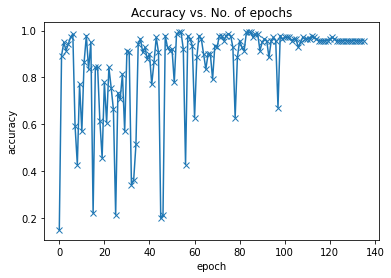

In [53]:
plot_accuracies(history)


In [54]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

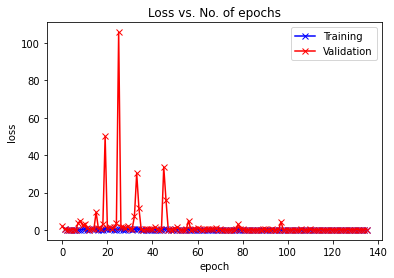

In [55]:
plot_losses(history)


In [56]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

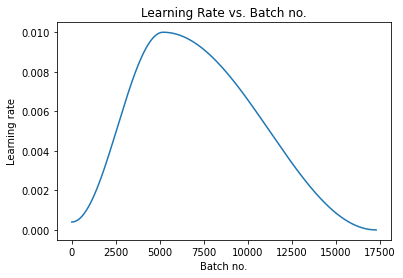

In [57]:
plot_lrs(history)


In [140]:
classification_model = TabletsModel(6)
classification_model.load_state_dict(torch.load('/home/frinks3/RISHABH/ACG/tablet_classification_effi.pth'))
to_device(classification_model, device)

TabletsModel(
  (network): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (sc

In [228]:
def predict_image(im, model):
    # Convert to a batch of 1
    # im=Image.open(img_path)
    # im= im.resize((130,200))
    img = data_transforms['val'](im)
    print(img.shape)
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    print(preds)
    print(class_names)
    print(f'defect----{class_names[preds[0].item()]}')
    plt.imshow(im)

In [219]:
image_dir='/home/frinks3/RISHABH/ACG/new/missc/new_missc'

torch.Size([3, 200, 130])
tensor([4], device='cuda:0')
['broken', 'chipping', 'double', 'empty', 'good', 'spot']
defect----good
torch.Size([3, 200, 130])
tensor([2], device='cuda:0')
['broken', 'chipping', 'double', 'empty', 'good', 'spot']
defect----double
torch.Size([3, 200, 130])
tensor([2], device='cuda:0')
['broken', 'chipping', 'double', 'empty', 'good', 'spot']
defect----double
torch.Size([3, 200, 130])
tensor([2], device='cuda:0')
['broken', 'chipping', 'double', 'empty', 'good', 'spot']
defect----double
torch.Size([3, 200, 130])
tensor([4], device='cuda:0')
['broken', 'chipping', 'double', 'empty', 'good', 'spot']
defect----good
torch.Size([3, 200, 130])
tensor([4], device='cuda:0')
['broken', 'chipping', 'double', 'empty', 'good', 'spot']
defect----good
torch.Size([3, 200, 130])
tensor([4], device='cuda:0')
['broken', 'chipping', 'double', 'empty', 'good', 'spot']
defect----good
torch.Size([3, 200, 130])
tensor([2], device='cuda:0')
['broken', 'chipping', 'double', 'empty', '

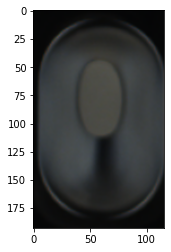

In [220]:
for img in os.listdir(image_dir):
    image=Image.open(image_dir+'/'+img)
    predict_image(image,resized_model)
    plt.imshow(image)
    
    

In [253]:
image_path='missc/new_missc/blister334.png'

In [254]:
cropped_img=cv2.imread(image_path)
cropped_pil_img= cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
cropped_pil_img=Image.fromarray(cropped_pil_img)

torch.Size([3, 200, 130])
tensor([2], device='cuda:0')
['broken', 'chipping', 'double', 'empty', 'good', 'spot']
defect----double


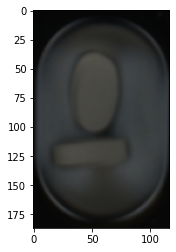

In [255]:
predict_image(cropped_pil_img,resized_model)

In [60]:
# model_complete.load_state_dict(torch.load('/content/drive/MyDrive/tablet_defects_classification/resnet34classes7.pth'))